In [179]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants

from bigbrain.brain import bleaching_correction
from bigbrain.brain import z_score_brain
from bigbrain.brain import get_resolution
from bigbrain.fictrac import load_fictrac
from bigbrain.fictrac import prep_fictrac
from bigbrain.utils import load_timestamps
from bigbrain.utils import sort_nicely
from bigbrain.utils import send_email
from bigbrain.glm import fit_glm
from bigbrain.glm import save_glm_map
from bigbrain.motcorr import get_motcorr_brain

In [2]:
class Fly:
    def __init__(self):
        pass
    
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

fly_folders = sorted(os.listdir(root_path))
fly_folders = [x for x in fly_folders if 'fly' in x]
sort_nicely(fly_folders)

flies = [Fly() for i in range(len(fly_folders))]

print('Created flies from folders {}'.format(fly_folders))
sys.stdout.flush()

desired_flies = [21] # 1 index
fly_folders = [fly_folders[i-1] for i in desired_flies]
flies = [flies[i-1] for i in desired_flies]
print(fly_folders)
sys.stdout.flush()

fly_idx = 0
folder = root_path + fly_folders[fly_idx]

Created flies from folders ['fly_1', 'fly_2', 'fly_3', 'fly_4', 'fly_5', 'fly_6', 'fly_7', 'fly_8', 'fly_9', 'fly_10', 'fly_11', 'fly_12', 'fly_13', 'fly_14', 'fly_15', 'fly_16', 'fly_17', 'fly_18', 'fly_19', 'fly_20', 'fly_21', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']
['fly_21']


In [25]:
file = os.path.join(folder, 'pca_out_flipped.npy')

In [26]:
pca2 = np.load(file)

In [7]:
pca.shape

(4170, 4170)

In [ ]:
# this should give me [time, PC]

In [27]:
pca2.shape

(535936, 4170)

In [35]:
pca_brain = np.reshape(pca2,(128,79,53,4170))

In [36]:
pca_brain.shape

(128, 79, 53, 4170)

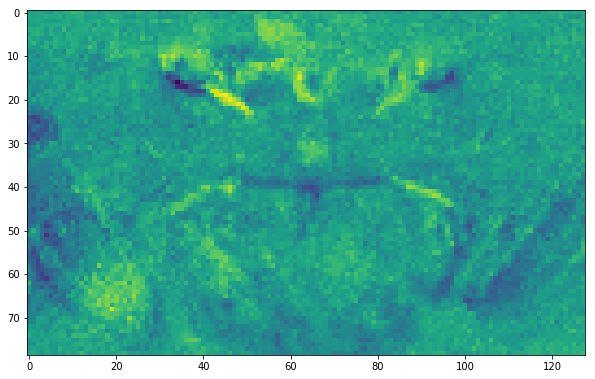

In [271]:
plt.figure(figsize=(10,10))
to_show = pca_brain[:,:,27,6]
to_show = np.swapaxes(to_show, 0, 1)
plt.imshow(to_show)
plt.show()

In [372]:
folder

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_21'

In [380]:
for i in range(20):
    file = 'PC{}.nii'.format(i+1)
    ants_brain = ants.from_numpy(pca_brain[:,:,:,i])
    save_file = os.path.join(folder, 'PCs', file)
    ants.image_write(ants_brain, save_file)

In [419]:
file = 'PCgrid_rec.nii'
ants_brain = ants.from_numpy(test)
save_file = os.path.join(folder, 'PCs', file)
ants.image_write(ants_brain, save_file)

In [388]:
# layer 20PCs into grid
grid = pca_brain[:,:,:,0]
for i in range(1,20):
    grid = np.concatenate((grid, pca_brain[:,:,:,i]), axis=0)

In [395]:
grid.shape

(2560, 79, 53)

In [412]:
rows = []
for i in range(4):
    rows.append(grid[int(640*i):int(640*(i+1)),:,:])

In [411]:

i=0
int(640*i+1)

1

In [405]:
i=0
test = grid[0:640,:,:]
test.shape

(640, 79, 53)

In [415]:
rows = np.asarray(rows)

In [418]:
test = np.concatenate((rows[0,:,:,:],
                       rows[1,:,:,:],
                       rows[2,:,:,:],
                       rows[3,:,:,:]), axis=-2)

In [417]:
test.shape

(640, 158, 53)

In [392]:
grid_rec = np.reshape(grid, (640, 79*4, 53))

In [387]:
pca_brain[:,:,:,0].shape

(128, 79, 53)

In [391]:
2560/4

640.0

In [394]:
grid_rec.shape

(640, 316, 53)

In [33]:
dims

{'t': 4170, 'x': 79, 'y': 128, 'z': 53}

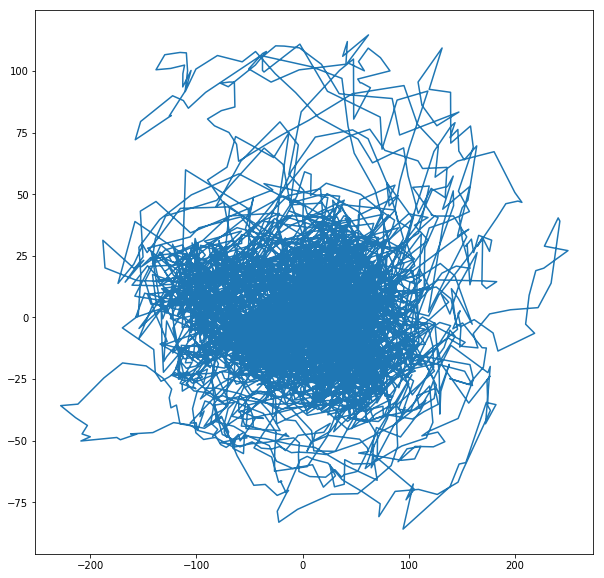

In [249]:
plt.figure(figsize=(10,10))
plt.plot(pca[:,0], pca[:,6])
plt.show()

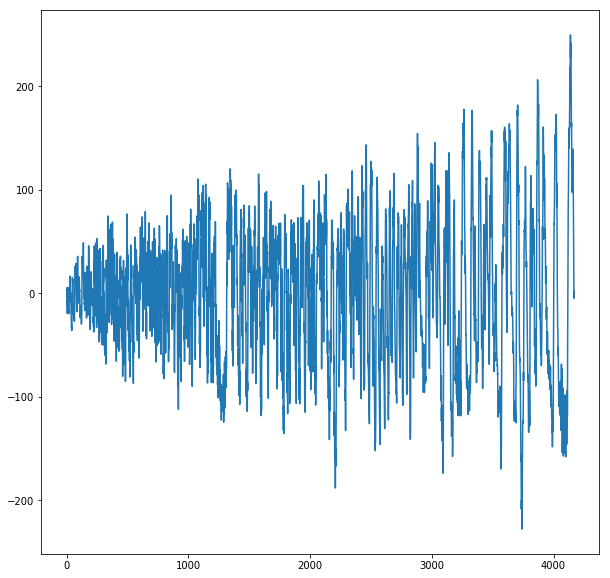

In [78]:
plt.figure(figsize=(10,10))
plt.plot(pca[:,0])
plt.show()

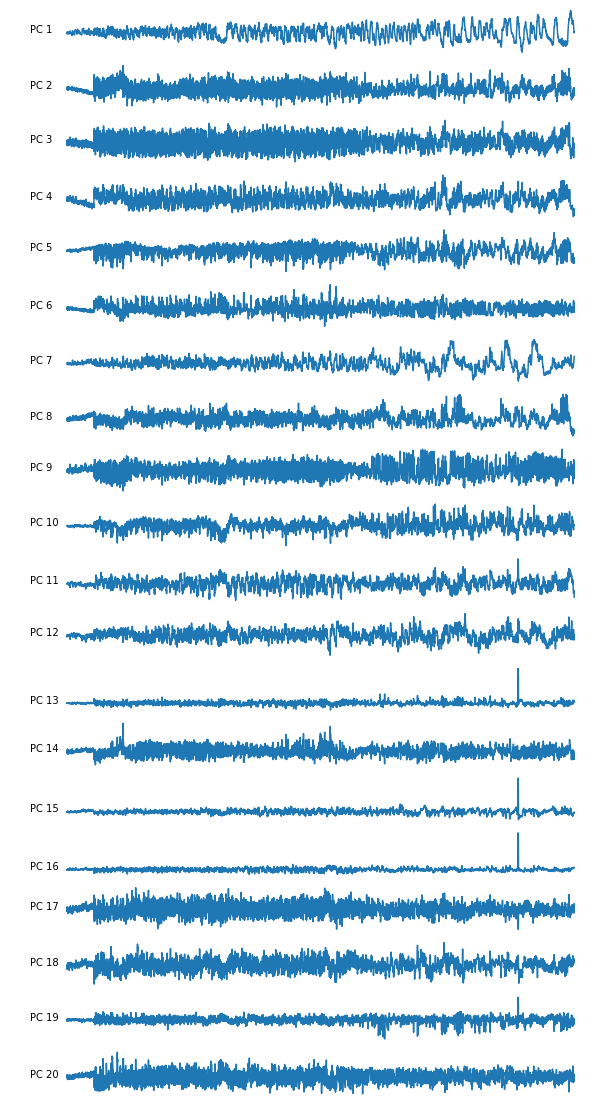

In [104]:
plt.figure(figsize=(10,20))
for i in range(20):
    plt.subplot(20,1,i+1)
    plt.plot(pca[:,i])
    plt.axis('off')
    plt.text(x=-300, y=0, s='PC {}'.format(i+1))
plt.show()

In [189]:
pca.shape

(4170, 4170)

In [ ]:
fictrac = load_fictrac(root_path, fly_folders[fly_idx])
fictrac_interp = prep_fictrac(fictrac, timestamps, fps, dur)

# remove first bit of data since it often has some weirdness
timestamps = timestamps[vols_to_clip:,:]
fictrac_interp = fictrac_interp[vols_to_clip:,:]

In [354]:
#accepts numpy fictrac
def interp_smooth_fictrac(fictrac, timestamps, columns, fps, dur):

    camera_rate = 1/fps * 1000 # camera frame rate in ms
    raw_fictrac_times = np.arange(0,dur,camera_rate)
    
    # Cut off any extra frames (only happened with brain 4)
    fictrac = fictrac[:90000]
    
    fictrac_interps = []
    
    for column in columns:
        # Smooth
        fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[column]),sigma=100)
        print(np.shape(fictrac_smoothed))
        # Interpolate
        # Warning: interp1d set to fill in out of bounds times
        fictrac_interp_temp = interp1d(raw_fictrac_times, fictrac_smoothed, bounds_error = False)
        fictrac_interp = fictrac_interp_temp(timestamps)

        # Replace Nans with zeros (for later code)
        np.nan_to_num(fictrac_interp, copy=False);
        
        fictrac_interps.append(fictrac_interp)
        print(np.shape(fictrac_interp))
    
    return np.asarray(fictrac_interps)

In [355]:
out = interp_smooth_fictrac(fictrac, timestamps, columns, fps, dur)

(90000,)
(4370, 53)
(90000,)
(4370, 53)
(90000,)
(4370, 53)
(90000,)
(4370, 53)


In [347]:
out.shape

(4, 4370, 53)

In [420]:
3

3

In [421]:
3

3

In [356]:
out = out[:,200:,:]

In [339]:
out.shape

(4, 4170, 53)

In [184]:
fps = 50 #of fictrac camera
dur = 30 * 60 * 1000 # experiment duration in ms
vols_to_clip = 200
fly_idx = 0


### Load timestamps ###
timestamps = load_timestamps(folder)

Loading timestamps.
loading timestamp data from hdf5 file... done
 load_timestamps Elapsed time: 6.201267242431641e-05min


In [185]:
columns = ['dRotLabX', 'dRotLabY', 'dRotLabZ', 'speed']

In [181]:
out.shape

(4, 4370, 53)

In [105]:
fictrac = load_fictrac(root_path, fly_folders[fly_idx])

Loading fictrac.
 load_fictrac Elapsed time: 0.07100736300150554min


In [109]:
list(fictrac)

['frameCounter',
 'dRotCamX',
 'dRotCamY',
 'dRotCamZ',
 'dRotScore',
 'dRotLabX',
 'dRotLabY',
 'dRotLabZ',
 'AbsRotCamX',
 'AbsRotCamY',
 'AbsRotCamZ',
 'AbsRotLabX',
 'AbsRotLabY',
 'AbsRotLabZ',
 'positionX',
 'positionY',
 'heading',
 'runningDir',
 'speed',
 'integratedX',
 'integratedY',
 'timeStamp',
 'sequence']

In [107]:
fictrac_numpy = np.asarray(fictrac)

In [132]:
test = fictrac_numpy[:,(4,5,6)]

In [133]:
test.shape

(90000, 3)

In [131]:
fictrac_numpy.shape

(90000, 23)

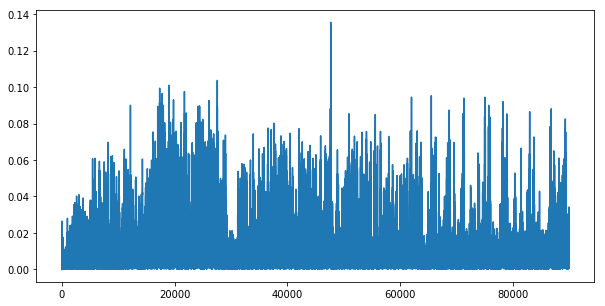

In [114]:
plt.figure(figsize=(10,5))
plt.plot(fictrac_numpy[:,18])
plt.show()

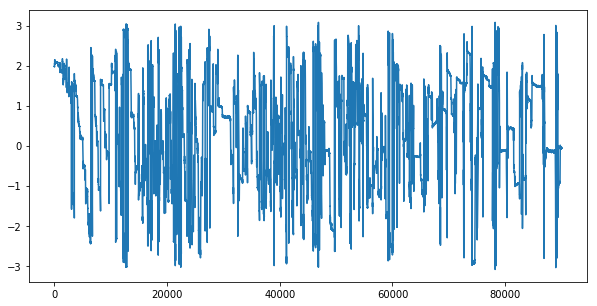

In [115]:
plt.figure(figsize=(10,5))
plt.plot(fictrac_numpy[:,13])
plt.show()

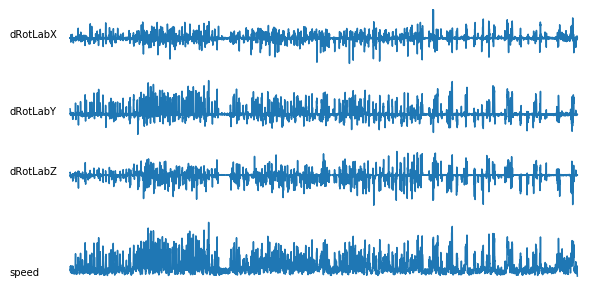

In [200]:
plt.figure(figsize=(10,5))
num=0
for i in range(4):
    num+=1
    plt.subplot(4,1,num)
    plt.plot(out[i,:,20])
    plt.axis('off')
    plt.text(x=-500, y=0, s='{}'.format(columns[i]))
plt.show()

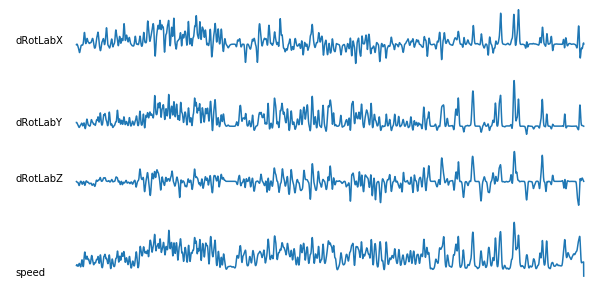

In [362]:
plt.figure(figsize=(10,5))
num=0
for i in range(4):
    num+=1
    plt.subplot(4,1,num)
    plt.plot(out[i,:,20])
    plt.axis('off')
    plt.text(x=-500, y=0, s='{}'.format(columns[i]))
plt.show()

In [116]:
for i in range(11,14):
    print(i)

11
12
13


In [124]:
np.max(fictrac_numpy[:,13])

3.0840785303943

In [357]:
behavior = out[:,:,20]

In [213]:
behavior.shape

(4170, 4)

In [358]:
behavior = np.swapaxes(behavior,0,1)

In [273]:
behavior.shape

(4170, 4)

In [363]:
diff = np.diff(np.swapaxes(behavior,0,1))

In [364]:
diff.shape

(4, 4169)

In [304]:
end = np.zeros((4,1))

In [311]:
end.shape

(4, 1)

In [365]:
diff_full = np.append(diff,end,1)

In [366]:
diff_full = np.swapaxes(diff_full, 0 ,1)

In [328]:
behavior.shape

(4, 4170)

In [367]:
# stack the 4 behavior vectors and 20 PC vectors
for_corr = np.hstack((behavior, diff_full, pca[:,:20]))

In [368]:
for_corr.shape

(4170, 28)

In [369]:
test = np.corrcoef(np.swapaxes(for_corr,0,1))

In [238]:
test[3,4]

0.3739301301244672

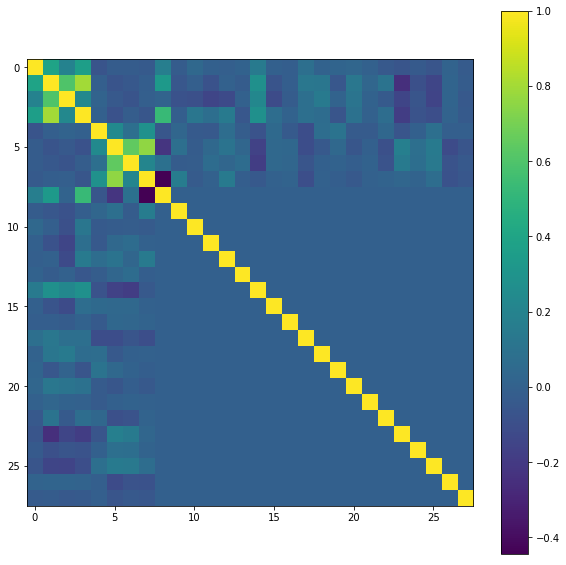

In [370]:
plt.figure(figsize=(10,10))
plt.imshow(test)
plt.colorbar()
plt.show()

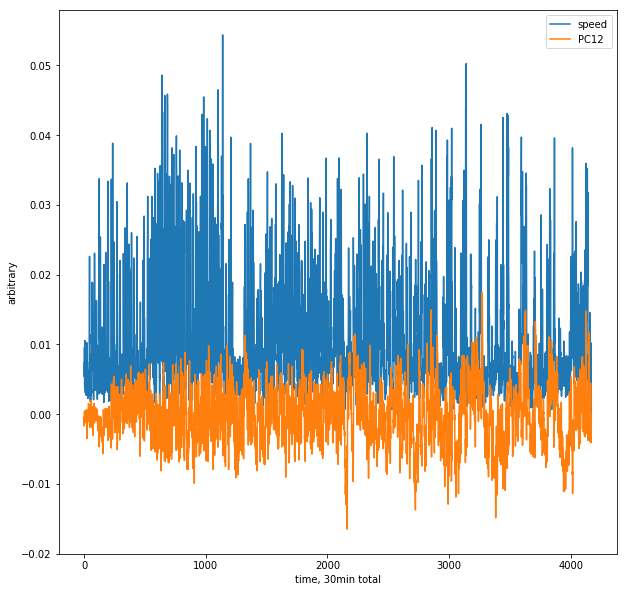

In [245]:
plt.figure(figsize=(10,10))
plt.plot(behavior[:,-1], label='speed')
#plt.plot(pca[:,0]/5000, label='PC1')
#plt.plot(pca[:,6]/5000, label='PC7')
plt.plot(pca[:,11]/5000, label='PC12')


plt.ylabel('arbitrary')
plt.xlabel('time, 30min total')
plt.legend()
plt.show()

In [229]:
behavior.shape

(4170, 4)

In [7]:
class Fly:
    def __init__(self):
        pass
    
root_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/'

fly_folders = sorted(os.listdir(root_path))
fly_folders = [x for x in fly_folders if 'fly' in x]
sort_nicely(fly_folders)

flies = [Fly() for i in range(len(fly_folders))]

print('Created flies from folders {}'.format(fly_folders))
sys.stdout.flush()

desired_flies = [21] # 1 index
fly_folders = [fly_folders[i-1] for i in desired_flies]
flies = [flies[i-1] for i in desired_flies]
print(fly_folders)
sys.stdout.flush()

Created flies from folders ['fly_1', 'fly_2', 'fly_3', 'fly_4', 'fly_5', 'fly_6', 'fly_7', 'fly_8', 'fly_9', 'fly_10', 'fly_11', 'fly_12', 'fly_13', 'fly_14', 'fly_15', 'fly_16', 'fly_17', 'fly_18', 'fly_19', 'fly_20', 'fly_21', 'fly_22', 'fly_23', 'fly_24', 'fly_25', 'fly_26']
['fly_21']


In [29]:
brain, dims = get_motcorr_brain(folder, channel='green')

Trying to load green motion-corrected brain.
Loaded green motion-corrected brain.
 get_motcorr_brain Elapsed time: 0.32704298893610634min


In [31]:
brain = brain[:,:,:,200:]
dims['t'] = brain.shape[3]

In [32]:
dims

{'t': 4170, 'x': 79, 'y': 128, 'z': 53}

In [8]:
fps = 50 #of fictrac camera
dur = 30 * 60 * 1000 # experiment duration in ms
vols_to_clip = 200
fly_idx = 0

folder = root_path + fly_folders[fly_idx]

### Load timestamps ###
timestamps = load_timestamps(folder)

### Load fictrac (and prep) ###
fictrac = load_fictrac(root_path, fly_folders[fly_idx])
fictrac_interp = prep_fictrac(fictrac, timestamps, fps, dur)

# remove first bit of data since it often has some weirdness
timestamps = timestamps[vols_to_clip:,:]
fictrac_interp = fictrac_interp[vols_to_clip:,:]

channel = 'green'
### Load brain ###
brain, dims = get_motcorr_brain(folder, channel=channel)

# remove first bit of data since it often has some weirdness
brain = brain[:,:,:,vols_to_clip:]
dims['t'] = brain.shape[3]

### Bleaching correction (per voxel) ###
brain = bleaching_correction(brain)

### Z-score brain ###
brain = z_score_brain(brain)

Loading timestamps.
loading timestamp data from hdf5 file... done
 load_timestamps Elapsed time: 0.0006835261980692545min
Loading fictrac.
 load_fictrac Elapsed time: 0.05859729051589966min
Preping fictrac.
 prep_fictrac Elapsed time: 0.0003850539525349935min
Trying to load green motion-corrected brain.
Loaded green motion-corrected brain.
 get_motcorr_brain Elapsed time: 0.3411370078722636min
Bleaching correction.
 bleaching_correction Elapsed time: 13.632637170950572min
Z-score brain.
 z_score_brain Elapsed time: 1.0880313793818155min


In [10]:
folder

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_21'

In [11]:
save_file = os.path.join(folder, 'brain_z.nii')
ants.image_write(ants.from_numpy(brain), save_file)

In [12]:
from sklearn.decomposition import PCA

In [13]:
#every row is a time point of the whole brain (so flatten brain for each row)
t0 = time()
X = np.reshape(brain, (-1, brain.shape[-1]))
print(time()-t0)

9.5367431640625e-05


In [18]:
X = np.swapaxes(X, 0, 1)

In [19]:
X.shape

(4170, 535936)

In [ ]:
t0 = time()
pca = PCA()
PCs = pca.fit_transform(X)
print(time()-t0)

In [ ]:
# this should give me [time, PC]

In [ ]:
save_file = os.path.join(directory, 'motcorr_params')
np.save(save_file,transform_matrix)

In [ ]:
### Fit GLM ###
scores = fit_glm(brain, dims, fictrac_interp, beta_len)

### Save brain ###
save_glm_map(scores, folder, channel)

### Send email ###

# Prep timing string
func_str = ''
for func in function_durations:
    func_str += '{} ===== {:.2f} min\n'.format(func['name'], func['duration'])
print(func_str)
sys.stdout.flush()

#send_email('Success {} ({} of {}):{} {} channel.'.format(fly_folders[fly_idx], fly_idx+1, len(flies)), func_str, channel)
print('Reached END.')
sys.stdout.flush()
